<a href="https://colab.research.google.com/github/zmohaveri/IVT-ActiveLearning/blob/main/IVT_dispendix_analysis_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import

In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from math import sqrt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from collections import OrderedDict 
import tensorflow as tf
from sklearn.model_selection import train_test_split
import datetime as tm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations 
from string import ascii_uppercase as alphabets

import glob
import os

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
plt.clf()

<Figure size 432x288 with 0 Axes>

In [3]:
%matplotlib inline

#Import and clean the data

##get all data and build dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def extract_slopes(data_path, fitting_range=(0,1900)):
  df = pd.read_excel(data_path,header=11).drop(columns='Time [s]')
  df['Unnamed: 0'] = df['Unnamed: 0'].astype(str) + df['Unnamed: 1'].astype(str)
  df = df.drop(columns='Unnamed: 1')
  df.rename(columns={"Unnamed: 0": "well_name"}, inplace='True')

  time = df.keys()[1:].to_numpy()
  n_samples = len(df)

  fit_df = fit_line_to_range(df,fitting_range,time)

  return fit_df


def fit_line_to_range(df,fitting_range: tuple,time):
  fitting_range_index = (fitting_range[0]//time[1],fitting_range[1]//time[1])
  time_interval = time[fitting_range_index[0] : fitting_range_index[1]]
  size = len(df)
  fit_df = pd.DataFrame(columns=['well_name','slopes','intercepts'])
  for i in range(size):
    fit = linregress(time_interval.astype(float), df.loc[i][fitting_range_index[0]+1 : fitting_range_index[1]+1].to_numpy().astype(float))
    slope = fit[0]#slope
    intercept = fit[1]
    name = df['well_name'][i]
    fit_df.loc[i] = [name, slope, intercept]

  return fit_df


In [22]:
def build_dataset(main_path='/content/drive/MyDrive/Thesis/IVT/dispendix/data/**',fitting_range=(0,1900)):
  dataset_df = pd.DataFrame()   #(columns=['well_name',	'spermidine',	'template',	'mgcl2',	'rntp','slopes','intercepts'])
  for folder in glob.iglob(main_path):
    if os.path.isdir(folder): 
      data_df, scanning_labels  = extract_iteration_data(folder,fitting_range)
      dataset_df = dataset_df.append(data_df.drop(columns='well_name'))
  data_with_rep = dataset_df.copy()
  dataset_df = dataset_df.groupby(scanning_labels).mean()
  return dataset_df, data_with_rep

def extract_iteration_data(folder_path,fitting_range=(0,1900)):
  for filepath in glob.iglob(folder_path+'/*concentrations.csv'):
    df = pd.read_csv(filepath)
    columns = df.columns.tolist() 
    cols_to_use = columns[:len(columns)-1] # drop the last column
    concentrations_df = pd.read_csv(filepath, usecols=cols_to_use)

  for filepath in glob.iglob(folder_path+'/*Measurements.xlsx'):
    fit_df = extract_slopes(filepath,fitting_range)
    

  data_df = pd.merge(concentrations_df, fit_df, on='well_name')
  scanning_labels = concentrations_df.keys().drop('well_name').tolist()

  return data_df , scanning_labels

In [25]:
dataset_df, data_with_rep = build_dataset()

In [32]:
dataset_df

,,,,slopes,intercepts
spermidine,template,mgcl2,rntp,,
0.02152876833142303,95.23207767186518,143.10464180984184,0.9847087691706968,0.002492,682.381818
0.062337550982015655,153.91264330762155,78.4861265671817,4.28212905484041,4.713098,-186.809091
0.11623389002402451,16.136738422476515,165.70020862077715,2.7098979688052776,-0.017222,651.100000
0.1183816784710423,31.136445856774113,41.473296536343476,2.1230639941471594,3.971077,461.427273
0.17560331533827356,193.75605594796642,183.8144310633305,3.1100230728395157,-0.016919,676.754545
...,...,...,...,...,...
9.64975547797833,62.32946278285184,56.52436226041098,3.0662172289335548,1.109663,418.372727
9.861589921454165,108.14719435549787,10.66563066736862,2.724431365412825,2.714966,903.727273
9.891616974582526,154.21956804045206,108.0123561522101,3.5129162575956836,0.178956,656.445455


In [64]:
dataset_x = np.array([[float(x) for x in row] for row in dataset_df.index.values]) #This is just to get an array out of df, because index values are returned as tuples of strings instead of list of floats.
dataset_x.shape

(192, 4)

In [65]:
dataset_y = dataset_df['intercepts'].to_numpy()
dataset_y.shape

(192,)

#NN Model

##model

In [91]:
def train_model(x_train,y_train,x_test,y_test,batch_size,input_size,layer_sizes,activations,optimizer,epochs,loss='MeanSquaredError'):
  assert len(layer_sizes) == len(activations)
  n_layers=len(layer_sizes)
  model = Sequential([LayerNormalization(input_shape=(input_size,)),
                      Dense(layer_sizes[0],activation=activations[0],input_shape=(input_size,),name='layer1')])
  for i in range(1,n_layers):
    model.add(Dense(layer_sizes[i],activation=activations[i],name=f'layer{i+1}'))
  
  model.compile(
    optimizer = optimizer,
    loss = loss, #MeanSquaredLogarithmicError
  )

  print(model.summary())

  history=model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs)
  loss_history=history.history['loss']

  plt.scatter(x=np.arange(1,epochs+1),y=loss_history)
  plt.show()

  loss=model.evaluate(x_test,y_test)
  print('test loss: ',loss)

  return model
  

In [93]:
x_train,x_test,y_train,y_test = train_test_split(dataset_x,dataset_y,test_size=0.2,random_state=100)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(153, 4) (39, 4) (153,) (39,)


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization_11 (Laye (None, 4)                 8         
_________________________________________________________________
layer1 (Dense)               (None, 10)                50        
_________________________________________________________________
layer2 (Dense)               (None, 6)                 66        
_________________________________________________________________
layer3 (Dense)               (None, 4)                 28        
_________________________________________________________________
layer4 (Dense)               (None, 1)                 5         
Total params: 157
Trainable params: 157
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
16/16 [==============================] - 0s 1ms/step - loss: 526687.6875
Epoch 2/500
16/16 [============

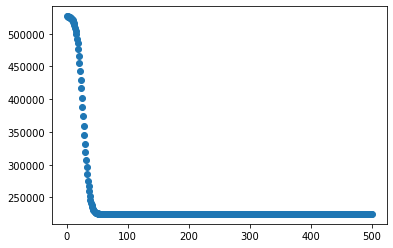

2/2 [==============================] - 0s 3ms/step - loss: 221940.9688
test loss:  221940.96875


In [94]:
layer_sizes = [10,6,4,1]
activations = ['sigmoid','relu','relu','relu']
opt = Adam(learning_rate=0.002)
model = train_model(x_train,y_train,x_test,y_test,batch_size=10,input_size=4,layer_sizes=layer_sizes,activations=activations,optimizer=opt,epochs=500)

#Using the trained model to find the maximum Yield

##Generating random grid

In [95]:
def random_points_in_range(n,ranges):
  points = np.empty((n,len(ranges)))
  for i,element in enumerate(ranges):
    start=min(element[1],element[0])
    interval=abs(element[1]-element[0])
    rand_check = np.random.rand(n)
    randoms = ( rand_check*interval ) + start
    points[:,i] = randoms.T
  return points

In [96]:
def run_n_times(n):
  arr=np.empty((n,4))
  for i in range(n):
    random_grid=random_points_in_range(10000,[(0,100),(0,1000),(0,1000),(0,5)])
    preds=model.predict(random_grid)
    preds_h=np.array(list(preds))
    max_array_index=np.argmax(preds)
    max=preds[max_array_index]
    max_index=random_grid[max_array_index]
    arr[i]= max_index
    print(max,max_index)
  print('avg:\n',np.average(arr,axis=0))

In [97]:
run_n_times(30)

[547.78217] [ 88.23409833 254.95107055 266.19221109   0.66074759]
[547.78217] [6.25411763e+01 1.96659338e+02 2.09541581e+02 1.95396736e-01]
[547.78217] [ 86.32072233 166.13694091 140.35466402   4.63958461]
[547.78217] [ 73.49567691 239.27945228 256.64638642   0.91498926]
[547.78217] [ 79.63173318 294.75221904 222.26629566   1.32662314]
[547.78217] [ 95.00187663 233.5068914  210.87437874   4.61147725]
[547.78217] [ 96.11361177 235.08222488 243.863096     0.97742737]
[547.78217] [ 98.7008991  302.81640633 206.47987881   0.75293812]
[547.78217] [ 66.47481055 252.74286367 223.61882674   3.68260808]
[547.78217] [4.90081577e+01 1.60634988e+02 1.55354489e+02 3.75689839e-02]
[547.78217] [ 58.17309015 115.08200687 141.00752056   3.87872845]
[547.78217] [ 79.78335068 113.50603387 133.64178202   3.39214146]
[547.78217] [ 94.06602892 193.4043276  170.62063108   4.37666824]
[547.78217] [ 58.3307757  194.95102863 130.81435335   2.66254543]
[547.78217] [ 67.77769942  81.88506708 101.14514679   3.2607